In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import folium
import os
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import  roc_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pickle

import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

# Data Cleaning

In [2]:
# Import world literacy data and clean it
literacy_df = pd.read_csv('world_literacy_rates.csv').drop(columns=['Code'])
literacy_df = literacy_df.rename(columns={'Literacy rates (World Bank, CIA World Factbook, and other sources) (%)'
                                          : 'literacy_rates'})
literacy_df.head()

,Entity,Year,literacy_rates
0,Afghanistan,1979,18.157681
1,Afghanistan,2011,31.741119
2,Afghanistan,2015,38.168041
3,Albania,2001,98.712982
4,Albania,2008,95.938637


In [3]:
# Export cleaned world literacy data for data visualization using another Jupyter Notebook file
literacy_df.to_csv('world_literacy_rates_cleaned.csv')

In [4]:
# List of features that would be included in the classification model.
select_list = ['case_status','class_of_admission','country_of_citizenship','country_of_citzenship','decision_date',
               'employer_city','employer_name','employer_postal_code','employer_state','job_info_work_city',
               'job_info_work_state','naics_2007_us_title','naics_us_title_2007','pw_amount_9089','pw_job_title_9089',
               'pw_level_9089','pw_soc_title','pw_unit_of_pay_9089','us_economic_sector','wage_offer_from_9089',
               'wage_offer_to_9089','wage_offer_unit_of_pay_9089','wage_offered_from_9089','wage_offered_to_9089',
               'wage_offered_unit_of_pay_9089','foreign_worker_info_education']

In [5]:
# Import US Permanent Visa data and only include the selected features
df = pd.read_csv('us_perm_visas.csv')
select_df = df.loc[:,select_list]

In [6]:
# This function cleans the wage value in string format before transforming it to numeric
def clean_string(x):
    if type(x)==str:
        return re.sub('[^0-9\.]+','',x)
    else: 
        return x

In [7]:
# This function rename the pay unit to the standardized form
def clean_pay_unit(x):
    pay_unit = {'yr': 'Year', 'hr': 'Hour', 'mth': 'Month', 'wk': 'Week', 'bi': 'Bi-Weekly'}
    if x in pay_unit:
        return pay_unit[x]
    else:
        return x

In [8]:
# This function rename the states to the standardized form
def clean_state(x):
    states = {'GEORGIA': 'GA', 'NEW YORK': 'NY', 'TEXAS': 'TX', 'CALIFORNIA': 'CA', 'WASHINGTON': 'WA',
              'NEW JERSEY': 'NJ', 'ARIZONA': 'AZ', 'NORTH CAROLINA': 'NC', 'WISCONSIN': 'WI',
              'LOUISIANA': 'LA', 'MAINE': 'ME', 'OHIO': 'OH', 'MARYLAND': 'MD', 'MASSACHUSETTS': 'MA',
              'MICHIGAN': 'MI', 'ILLINOIS': 'IL', 'PENNSYLVANIA': 'PA', 'VERMONT': 'VT', 'VIRGINIA': 'VA',
              'FLORIDA': 'FL', 'MISSOURI': 'MO', 'ARKANSAS': 'AR', 'NEW HAMPSHIRE': 'NH', 'INDIANA': 'IN',
              'OKLAHOMA': 'OK', 'UTAH': 'UT', 'CONNECTICUT': 'CT', 'SOUTH DAKOTA': 'SD', 'DELAWARE': 'DE',
              'ALABAMA': 'AL', 'WEST VIRGINIA': 'WV', 'NEBRASKA': 'NE', 'OREGON': 'OR', 'COLORADO': 'CO',
              'RHODE ISLAND': 'RI', 'KANSAS': 'KS', 'ALASKA': 'AK', 'DISTRICT OF COLUMBIA': 'DC',
              'MINNESOTA': 'MN', 'TENNESSEE': 'TN', 'KENTUCKY': 'KY', 'GUAM': 'GU', 'IOWA': 'IA', 'NEW MEXICO': 'NM',
              'NORTH DAKOTA': 'ND', 'NEVADA': 'NV', 'MISSISSIPPI': 'MS', 'IDAHO': 'ID', 'PUERTO RICO': 'PR',
              'SOUTH CAROLINA': 'SC', 'VIRGIN ISLANDS': 'VI', 'MONTANA': 'MT', 'HAWAII': 'HI', 'WYOMING': 'WY',
              'NORTHERN MARIANA ISLANDS': 'MP', 'MARSHALL ISLANDS': 'MH', 'FEDERATED STATES OF MICRONESIA': 'FM'}
    if x in states:
        return states[x]
    else:
        return x

In [9]:
# Clean features using clean_string, clean_pay_unit and clean_state function
select_df['wage_offer_from_9089'] = pd.to_numeric(select_df.wage_offer_from_9089.transform(clean_string))
select_df['wage_offer_to_9089'] = pd.to_numeric(select_df.wage_offer_to_9089.transform(clean_string))
select_df['wage_offer_unit_of_pay_9089'] = select_df.wage_offer_unit_of_pay_9089.transform(clean_pay_unit)
select_df['pw_unit_of_pay_9089'] = select_df.pw_unit_of_pay_9089.transform(clean_pay_unit)
select_df['job_info_work_state'] = select_df.job_info_work_state.transform(clean_state)
select_df['employer_state'] = select_df.employer_state.transform(clean_state)
select_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374362 entries, 0 to 374361
Data columns (total 26 columns):
case_status                      374362 non-null object
class_of_admission               351517 non-null object
country_of_citizenship           353729 non-null object
country_of_citzenship            20574 non-null object
decision_date                    374362 non-null object
employer_city                    374348 non-null object
employer_name                    374350 non-null object
employer_postal_code             374325 non-null object
employer_state                   374320 non-null object
job_info_work_city               374260 non-null object
job_info_work_state              374259 non-null object
naics_2007_us_title              19900 non-null object
naics_us_title_2007              111246 non-null object
pw_amount_9089                   372146 non-null object
pw_job_title_9089                223591 non-null object
pw_level_9089                    346735 non-null ob

In [10]:
# Calculate the mean wages from two wage features
select_df['wage1'] = select_df[['wage_offer_from_9089','wage_offer_to_9089']].mean(axis=1)
select_df['wage2'] = select_df[['wage_offered_from_9089','wage_offered_to_9089']].mean(axis=1)

In [11]:
# Combine duplicate features into one distinct features
select_df['country_of_citizenship'] = select_df.country_of_citizenship.fillna(select_df.country_of_citzenship)
select_df['naics_us_title_2007'] = select_df.naics_us_title_2007.fillna(select_df.naics_2007_us_title)
select_df['pw_job_title_9089'] = select_df.pw_job_title_9089.fillna(select_df.pw_soc_title)
select_df['wage1'] = select_df.wage1.fillna(select_df.wage2)
select_df['wage_offer_unit_of_pay_9089'] = select_df.wage_offer_unit_of_pay_9089.fillna(select_df.
                                                                                        wage_offered_unit_of_pay_9089)
select_df['wage_offer_unit_of_pay_9089'] = select_df.wage_offer_unit_of_pay_9089.fillna(select_df.
                                                                                        pw_unit_of_pay_9089)
select_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374362 entries, 0 to 374361
Data columns (total 28 columns):
case_status                      374362 non-null object
class_of_admission               351517 non-null object
country_of_citizenship           374303 non-null object
country_of_citzenship            20574 non-null object
decision_date                    374362 non-null object
employer_city                    374348 non-null object
employer_name                    374350 non-null object
employer_postal_code             374325 non-null object
employer_state                   374320 non-null object
job_info_work_city               374260 non-null object
job_info_work_state              374259 non-null object
naics_2007_us_title              19900 non-null object
naics_us_title_2007              131146 non-null object
pw_amount_9089                   372146 non-null object
pw_job_title_9089                373903 non-null object
pw_level_9089                    346735 non-null ob

In [12]:
# Drop the duplicate features
select_df = select_df.drop(columns=['country_of_citzenship','naics_2007_us_title','pw_soc_title',
                                    'wage_offer_from_9089','wage_offer_to_9089','wage_offered_from_9089',
                                    'wage_offered_to_9089','wage2','wage_offered_unit_of_pay_9089',
                                    'naics_us_title_2007','us_economic_sector','employer_city','employer_name',
                                    'employer_postal_code','employer_state','pw_amount_9089','pw_unit_of_pay_9089'])
select_df = select_df.dropna(subset=['wage1','pw_job_title_9089'])
select_df.isna().sum()

case_status                           0
class_of_admission                22504
country_of_citizenship               28
decision_date                         0
job_info_work_city                   34
job_info_work_state                  37
pw_job_title_9089                     0
pw_level_9089                     27187
wage_offer_unit_of_pay_9089        1129
foreign_worker_info_education    135025
wage1                                 0
dtype: int64

In [13]:
# Drop all the null value rows
select_df = select_df.dropna()
select_df.head()

,case_status,class_of_admission,country_of_citizenship,decision_date,job_info_work_city,job_info_work_state,pw_job_title_9089,pw_level_9089,wage_offer_unit_of_pay_9089,foreign_worker_info_education,wage1
135269,Certified,H-1B,INDIA,2015-05-29,Waukesha,WI,Industrial Engineers,Level IV,Year,Bachelor's,92500.0
135271,Denied,H-1B,GERMANY,2014-10-16,Aurora,CO,Protein Production Scientist,Level I,Year,Doctorate,65000.0
135272,Certified,E-2,SOUTH KOREA,2015-05-26,Lynnwood,WA,Market Research Analysts and Marketing Special...,Level I,Year,Master's,43514.0
135274,Certified,F-1,SOUTH KOREA,2015-05-28,East Lansing,MI,"Cooks, Restaurant",Level IV,Year,None,24710.0
135275,Certified-Expired,H-1B,CANADA,2014-12-01,New York,NY,Public Relations Specialists,Level II,Year,Bachelor's,55700.0


In [14]:
# Rename the features with simpler names
select_df = select_df.rename(columns={'job_info_work_city':'work_city','job_info_work_state':'job_state',
                                      'pw_level_9089':'job_level','wage_offer_unit_of_pay_9089':'wage_period',
                                      'wage1':'wage','pw_job_title_9089':'job_title',
                                      'foreign_worker_info_education':'education'}).reset_index().drop(columns=['index'])
select_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207030 entries, 0 to 207029
Data columns (total 11 columns):
case_status               207030 non-null object
class_of_admission        207030 non-null object
country_of_citizenship    207030 non-null object
decision_date             207030 non-null object
work_city                 207030 non-null object
job_state                 207030 non-null object
job_title                 207030 non-null object
job_level                 207030 non-null object
wage_period               207030 non-null object
education                 207030 non-null object
wage                      207030 non-null float64
dtypes: float64(1), object(10)
memory usage: 17.4+ MB


### Wage Period Correction

In [15]:
# These functions return the 5 percentila nd 95 percentile values
def q5(x):
    return x.quantile(0.05)
def q95(x):
    return x.quantile(0.95)

In [16]:
# Show the statistic of reported wages based on wage period
select_df.groupby('wage_period').agg({'wage':[q5,q95,'mean','min','max']})

wage                                                 
                    q5          q95           mean      min         max
wage_period                                                            
Bi-Weekly      919.894    2602.0315    1840.029000   887.08     2992.33
Hour             8.090      66.5000     183.360154     6.95   211500.00
Month         1880.000   67000.0000   13314.797245   875.00   146000.00
Week           385.000  119492.8500   18659.783621   300.00   149713.00
Year         41686.400  168610.7000  102353.966386  2200.60  9582600.00

In [17]:
# This function correct the wage period
def fix_pay_unit(pay_unit,wage):
    wage_range = {'Hour':[0,300],'Week':[100,5000],'Bi-Weekly':[200,10000], 'Month': [500,24000], 
                  'Year':[10000,15000000]}
    if pay_unit=='Year':
        return pay_unit
    if wage < wage_range[pay_unit][0] or wage > wage_range[pay_unit][1]:
        pay_unit_temp = pay_unit
        while pay_unit_temp!= 'Year':
            if pay_unit_temp=='Hour':
                pay_unit_temp = 'Week'
            elif pay_unit_temp=='Week':
                pay_unit_temp = 'Bi-Weekly'
            elif pay_unit_temp=='Bi-Weekly':
                pay_unit_temp = 'Month'
            elif pay_unit_temp=='Month':
                pay_unit_temp = 'Year'
            if wage >= wage_range[pay_unit_temp][0] and wage <= wage_range[pay_unit_temp][1]:
                return pay_unit_temp
            elif pay_unit_temp=='Year':
                return pay_unit
    else:
        return pay_unit

In [18]:
# This function convert the reported wages to same scale
def scale_wage(pay_unit, wage):
    wage_scale_factor = {'Hour':2000,'Week':52,'Bi-Weekly':26, 'Month':12, 'Year':1}
    return wage*wage_scale_factor[pay_unit]

In [19]:
# Apply correction to date using fix_pay_unit and scale_wage functions
select_df['wage_period'] = select_df.apply(lambda x: fix_pay_unit(x.wage_period,x.wage), axis=1)
select_df['scaled_wage'] = select_df.apply(lambda x: scale_wage(x.wage_period,x.wage), axis=1)

### Job Categorization

In [20]:
unique_job_list = list(select_df.job_title.unique())

In [26]:
# This iterator is used to find out the related job titles
for i in unique_job_list:
    if i.find('engineer')!=-1:
        print(i)

computer software engineers, application
Senior materials engineer
software engineer
electrical engineer
sales engineer
mechanical engineer
electronics engineer
sales engineer/technical recruiter
Computer system engineer
Industrial engineers
civil engineer
engineering teachers, postsecondary
Architectural and engineering managers
Senior mechancial engineer
nuclear engineer


In [27]:
select_df[select_df['job_title'].str.contains('Dispatc',na=False)]

,case_status,class_of_admission,country_of_citizenship,decision_date,work_city,job_state,job_title,job_level,wage_period,education,wage,scaled_wage
10212,Certified,B-2,POLAND,2015-07-15,Chicago,IL,Truck Dispatcher,Level IV,Year,None,49899.0,49899.0
69108,Denied,EWI,COSTA RICA,2015-06-29,Avenel,NJ,Trucking Dispatcher,Level IV,Year,None,50398.0,50398.0
82047,Certified-Expired,B-2,TUNISIA,2015-10-22,Santa Monica,CA,"Dispatchers, Except Police, Fire, and Ambulance",Level I,Year,None,24544.0,24544.0
113996,Certified-Expired,E-1,SOUTH KOREA,2016-02-10,LEONIA,NJ,"Dispatchers, Except Police, Fire, and Ambulance",Level I,Year,None,25230.0,25230.0
138481,Denied,EWI,COSTA RICA,2016-04-29,Avenel,NJ,"Dispatchers, Except Police, Fire, and Ambulance",Level IV,Year,None,54558.0,54558.0
189165,Certified,Not in USA,BRAZIL,2016-10-17,Beltsville,MD,"Dispatchers, Except Police, Fire, and Ambulance",Level II,Year,Bachelor's,33862.0,33862.0
193409,Certified,E-2,SOUTH KOREA,2016-10-31,Gardena,CA,"Dispatchers, Except Police, Fire, and Ambulance",Level I,Year,High School,25200.0,25200.0


In [30]:
# This function return the key word of job titles
def search_word(job_list):
    keyword = Counter()
    for i in job_list:
        words = i.split()
        for word in words:
            keyword[word] +=1
    return keyword
job_title_word = search_word(unique_job_list)
job_title_word.most_common(5)

[('and', 920),
 ('Engineer', 350),
 ('Software', 340),
 ('&', 293),
 ('Manager', 262)]

In [31]:
# This function categorize job titles into 8 groups
def job_category(job_title):
    job_dict = {'administrat':'Secretary and Administration', 'secretar':'Secretary and Administration', 
                'clerk':'Secretary and Administration', 'nann':'Unskilled',
                'cook':'Food Preparation', 'chef':'Food Preparation','baker':'Food Preparation',
                'controller':'Management','president':'Management','director':'Management', 'manager':'Management',
                'supervisor':'Management', 'coordinator':'Management', 'planner':'Management', 'vp':'Management',
                'head of integrated production':'Management','comptroller':'Management','ceo':'Management',
                'producer':'Management','mgr':'Management','manger':'Management','mngrs':'Management','headmaster':'Management',
                'teacher':'Education', 'educat':'Education', 'profes':'Education', 'dean':'Education','faculty':'Education',
                'lecturer':'Education',
                'officer':'Secretary and Administration', 'assistant':'Secretary and Administration',
                'curator':'Secretary and Administration', 'operator':'Unskilled','pediatric':'STEM','hydrologist':'STEM',
                'pharmacist':'STEM','technician':'STEM','therapist':'STEM','gynecologist':'STEM','estimator':'STEM',
                'engineer':'STEM', 'computer':'STEM', 'scientist':'STEM','specialist':'STEM', 'pathologist':'STEM',
                'programmer':'STEM', 'analyst':'STEM', 'technologist':'STEM', 'physic':'STEM','internalist':'STEM',
                'developer':'STEM','chemist':'STEM','biolog':'STEM', 'pharmac':'STEM', 'statistic':'STEM','actuar':'STEM', 
                'chief':'Management', 'architect':'STEM', 'psycholog':'STEM', 'advisor':'Non-STEM Professional',
                'consultant':'Non-STEM Professional', 'accountant':'Non-STEM Professional','auditor':'Non-STEM Professional', 
                'animator':'Non-STEM Professional', 'drafter':'Non-STEM Professional','lawyer':'Non-STEM Professional',
                'designer':'Non-STEM Professional', 'attorney':'Non-STEM Professional','editor':'Non-STEM Professional',
                'translator':'Non-STEM Professional','writer':'Non-STEM Professional','reporter':'Non-STEM Professional',
                'trainer':'Non-STEM Professional','coach':'Non-STEM Professional','buyer':'Non-STEM Professional',
                'choreographer':'Non-STEM Professional','researcher':'Non-STEM Professional','assessor':'Non-STEM Professional',
                'physiologist':'Non-STEM Professional','clergy':'Non-STEM Professional','counsel':'Non-STEM Professional',
                'logistician':'STEM','epidemiologist':'STEM','economist':'STEM','psychiatrist':'STEM','cardiologist':'STEM',
                'veterinarian':'STEM','orthodontist':'STEM','nutritionist':'STEM','sonograph':'STEM','dentist':'STEM',
                'surgeon':'STEM', 'doctor':'STEM','internist':'STEM','anesth':'STEM','geographer':'STEM',
                'practitioner':'STEM','optometrist':'STEM','mathematician':'STEM','forester':'STEM','chiropractor':'STEM',
                'hygienist':'STEM','sociologist':'STEM','prosthetist':'STEM','audiologist':'STEM','optician':'STEM',
                'prosthodontists':'STEM','phlebotomist':'STEM','hospitalist':'STEM','data entry keyer':'STEM',
                'database':'STEM','analy':'STEM','quality control':'STEM','teller':'STEM','sys admin':'STEM',
                'astronomer':'STEM','podiatrist':'STEM','engineeer':'STEM','dba':'STEM','acupu':'STEM','modeler':'STEM',
                'software':'STEM','ceramist':'STEM','sap':'STEM','nephrologist':'STEM','anthropologist':'STEM',
                'archeologists':'STEM','acutaries':'STEM','neurologist':'STEM','mathemetician':'STEM','practioner':'STEM',
                'geriatrician':'STEM','clinician':'STEM','oncologist':'STEM','endocrinologist':'STEM','pulmonologist':'STEM',
                'analysis':'STEM','radiologist':'STEM','qa tester':'STEM','systems admin':'STEM','practicioner':'STEM',
                'lead':'Management','sale':'Sales','representative':'Non-STEM Professional','glazier':'Non-STEM Professional',
                'examin':'Non-STEM Professional','cosmetologist':'Non-STEM Professional','surveyor':'Non-STEM Professional',
                'dispatcher':'Non-STEM Professional','preparer':'Non-STEM Professional','stylist':'Non-STEM Professional',
                'recruiter':'Non-STEM Professional','tailor':'Non-STEM Professional','bookkeeper':'Non-STEM Professional',
                'minister':'Non-STEM Professional','weigher':'Non-STEM Professional','dancer':'Non-STEM Professional',
                'singer':'Non-STEM Professional','librari':'Non-STEM Professional','pressman':'Non-STEM Professional',
                'publisher':'Non-STEM Professional','fundraiser':'Non-STEM Professional','pilot':'Non-STEM Professional',
                'photogrammetrist':'Non-STEM Professional','promoters':'Non-STEM Professional','agent':'Non-STEM Professional',
                'inspector':'Non-STEM Professional','proofreaders':'Non-STEM Professional','photographer':'Non-STEM Professional',
                'machinist':'Non-STEM Professional','concierge':'Non-STEM Professional','transcriptionist':'Non-STEM Professional',
                'fabric menders':'Non-STEM Professional','collector':'Non-STEM Professional','artist':'Non-STEM Professional',
                'archivist':'Non-STEM Professional','taper':'Non-STEM Professional','instructor':'Non-STEM Professional',
                'jeweler':'Non-STEM Professional','pastor':'Non-STEM Professional','guide':'Non-STEM Professional',
                'paralegal':'Non-STEM Professional','actor':'Non-STEM Professional','broker':'Non-STEM Professional',
                'athletes and sports competitors':'Non-STEM Professional','research associate':'Non-STEM Professional',
                'driller':'Non-STEM Professional','treasurer':'Non-STEM Professional','announcer':'Non-STEM Professional',
                'umpire':'Non-STEM Professional','freight forwarder':'Non-STEM Professional','recepti':'Non-STEM Professional',
                'delineator':'Non-STEM Professional','interviewer':'Non-STEM Professional','expert':'Non-STEM Professional',
                'business':'Non-STEM Professional',
                'dietician':'STEM','endodontist':'STEM','geolog':'STEM','web dev.':'STEM','interists':'STEM',
                'worker':'Unskilled', 'farmer':'Unskilled', 'rancher':'Unskilled','laborer':'Unskilled','cleaner':'Unskilled',
                'janitor':'Unskilled', 'food server':'Unskilled','helper':'Unskilled', 'cutter':'Unskilled', 
                'packer':'Unskilled', 'trimmer':'Unskilled','welder':'Unskilled','itter':'Unskilled','plumber':'Unskilled',
                'handler':'Unskilled','carpenter':'Unskilled','painter':'Unskilled','mason':'Unskilled','housekeeper':'Unskilled',
                'mover':'Unskilled','setter':'Unskilled','maker':'Unskilled','aide':'Unskilled','mechanic':'Unskilled',
                'finisher':'Unskilled','repair':'Unskilled','assembler':'Unskilled','caretaker':'Unskilled',
                'caregiver':'Unskilled','breeder':'Unskilled','landscaper':'Unskilled','roofer':'Unskilled','host':'Unskilled',
                'driver':'Unskilled','electrician':'Unskilled','cashier':'Unskilled','installer':'Unskilled','wait':'Unskilled',
                'manicur':'Unskilled','garden':'Unskilled','upholsterer':'Unskilled','washer':'Unskilled','guard':'Unskilled',
                'attendant':'Unskilled','foreman':'Unskilled','maintenance':'Unskilled','presser':'Unskilled',
                'sewer':'Unskilled','telemarketer':'Unskilled','shampooer':'Unskilled','filler':'Unskilled',
                'loader':'Unskilled','processor':'Unskilled','barbers':'Unskilled','sorter':'Unskilled',
                'packager':'Unskilled','floor layer':'Unskilled','builder':'Unskilled','nurse':'STEM','molder':'Unskilled',
                'butcher':'Unskilled','barber':'Unskilled'}
    job_title = job_title.lower()
    for key in job_dict:
        if key in job_title:
            return job_dict[key]
    return 'Unknown'

In [32]:
# Shows the counts of each job catergory
job_counter = Counter()
for i in unique_job_list:
    job_counter[job_category(i)] +=1
job_counter

Counter({'STEM': 2322,
         'Food Preparation': 179,
         'Unknown': 137,
         'Management': 998,
         'Education': 494,
         'Secretary and Administration': 309,
         'Unskilled': 499,
         'Non-STEM Professional': 516,
         'Sales': 99})

In [33]:
# Assign job category to all data.
select_df['job_category'] = select_df.apply(lambda x: job_category(x.job_title), axis=1)

In [35]:
# Export the cleaned US Permanent Visa data for modeling using another Jupyter Notebook
final_df = select_df.copy()
final_df.to_csv('us_perm_visas_cleaned.csv')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207030 entries, 0 to 207029
Data columns (total 13 columns):
case_status               207030 non-null object
class_of_admission        207030 non-null object
country_of_citizenship    207030 non-null object
decision_date             207030 non-null object
work_city                 207030 non-null object
job_state                 207030 non-null object
job_title                 207030 non-null object
job_level                 207030 non-null object
wage_period               207030 non-null object
education                 207030 non-null object
wage                      207030 non-null float64
scaled_wage               207030 non-null float64
job_category              207030 non-null object
dtypes: float64(2), object(11)
memory usage: 20.5+ MB


# EDA

In [36]:
# This function calculate the visa certified ratio based on the group.
def certified_ratio(DF,GROUPNAME):
    
    DF = DF[(DF['case_status']=='Certified') | (DF['case_status']=='Denied')]
    
    select_df_app_by_XXX = DF.groupby([GROUPNAME,'case_status']).decision_date.count()\
    .reset_index(name='count')

    #select_df_temp1 = select_df_app_by_XXX[(select_df_app_by_XXX['case_status']=='Certified')\
    #                                       | (select_df_app_by_XXX['case_status']=='Certified-Expired')]\
    #.reset_index().drop(columns=['index','case_status']).rename(columns={'count':'certified_application'})
    select_df_temp1 = select_df_app_by_XXX[(select_df_app_by_XXX['case_status']=='Certified')]\
    .reset_index().drop(columns=['index','case_status']).rename(columns={'count':'certified_application'})

    select_df_temp2 = select_df_app_by_XXX.groupby([GROUPNAME]).agg({'count':'sum'})\
    .reset_index().rename(columns={'count':'total_application'})

    select_df_app_by_XXX = select_df_temp1.merge(select_df_temp2, on=GROUPNAME)

    select_df_app_by_XXX['certified_ratio']\
    = select_df_app_by_XXX['certified_application']/select_df_app_by_XXX['total_application']
    
    return select_df_app_by_XXX

In [37]:
# Certified Ratio by job category
select_df_app_byjobcat = certified_ratio(select_df,'job_category')\
.sort_values(by='certified_ratio', ascending=False)

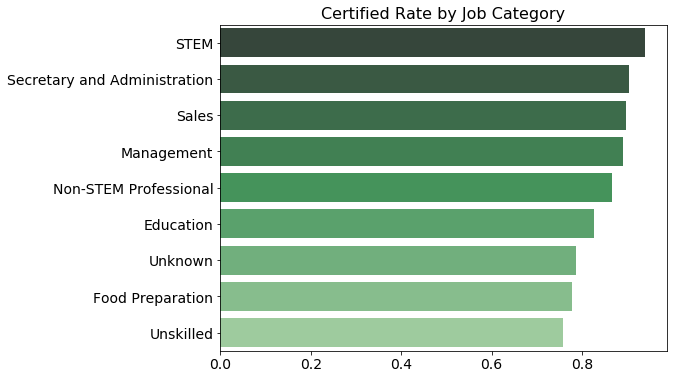

In [38]:
# Plot of Certified Ratio by job category
plt.figure(figsize=(8, 6))
plt.xticks(size='14')
plt.yticks(size='14')
plt.title('Certified Rate by Job Category', size='16')
sns.barplot(y='job_category', x='certified_ratio', data=select_df_app_byjobcat, 
                    palette='Greens_d')
plt.xlabel('',fontsize='16')
plt.ylabel('',fontsize='16');

In [39]:
# Certified Ratio by job level
select_df_app_byjoblevel = certified_ratio(select_df,'job_level')\
.sort_values(by='certified_ratio', ascending=False)

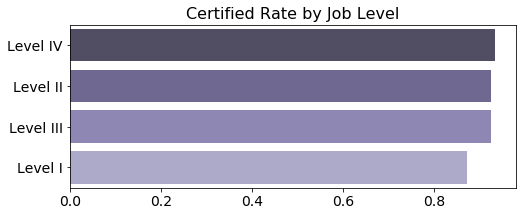

In [41]:
#Plot of Certified Ratio by job level
plt.figure(figsize=(8, 3))
plt.xticks(size='14')
plt.yticks(size='14')
plt.title('Certified Rate by Job Level', size='16')
sns.barplot(y='job_level', x='certified_ratio', data=select_df_app_byjoblevel, 
                    palette='Purples_d')
plt.xlabel('',fontsize='16')
plt.ylabel('',fontsize='16');

In [42]:
# Certified Ratio by applicant education
select_df_app_byeducation = certified_ratio(select_df,'education')\
.sort_values(by='certified_ratio', ascending=False)

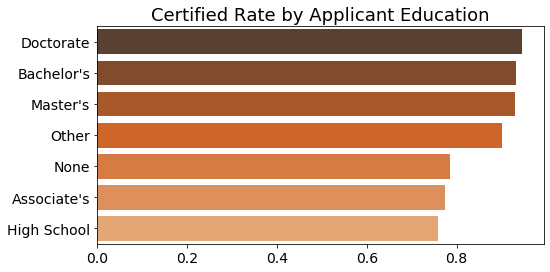

In [44]:
# Certified Ratio by applicant education
plt.figure(figsize=(8, 4))
plt.xticks(size='14')
plt.yticks(size='14')
plt.title('Certified Rate by Applicant Education', size='18')
sns.barplot(y='education', x='certified_ratio', data=select_df_app_byeducation, 
                    palette='Oranges_d')
plt.xlabel('',fontsize='16')
plt.ylabel('',fontsize='16');

In [45]:
# Certified Ratio by admission class
select_df_app_byadmissionclass = certified_ratio(select_df,'class_of_admission')\
.sort_values(by='certified_ratio', ascending=False)

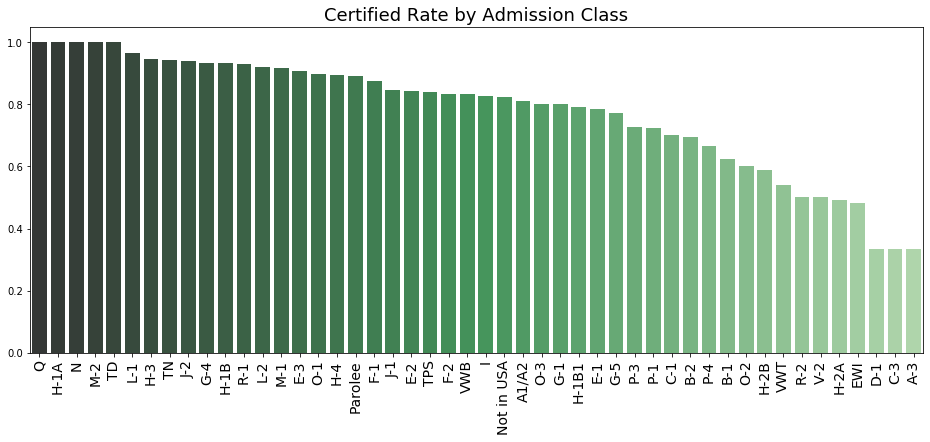

In [46]:
# Plot of Certified Ratio by admission class
plt.figure(figsize=(16, 6))
plt.xticks(rotation = 90, size='14')
plt.title('Certified Rate by Admission Class', size='18')
sns.barplot(x='class_of_admission', y='certified_ratio', data=select_df_app_byadmissionclass, 
                    palette='Greens_d')
plt.xlabel('',fontsize='16')
plt.ylabel('',fontsize='16');

In [47]:
# Certified Ratio by Wage Period
select_df_app_bypayunit = certified_ratio(select_df,'wage_period')\
.sort_values(by='certified_ratio', ascending=False)

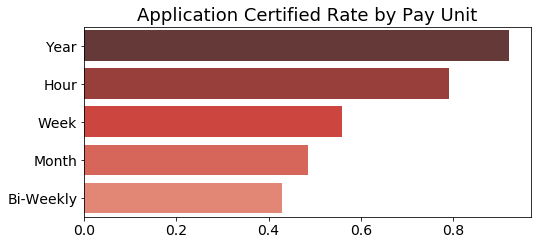

In [48]:
# Plot of Certified Ratio by Wage Period
plt.figure(figsize=(8, 3.5))
plt.xticks(size='14')
plt.yticks(size='14')
plt.title('Application Certified Rate by Pay Unit', size='18')
sns.barplot(y='wage_period', x='certified_ratio', data=select_df_app_bypayunit, 
                    palette='Reds_d')
plt.xlabel('',fontsize='16')
plt.ylabel('',fontsize='16');

In [49]:
# Certified Ratio by citizenship
select_df_app_bycitizenship = certified_ratio(select_df,'country_of_citizenship')\
.sort_values(by='certified_ratio', ascending=False)

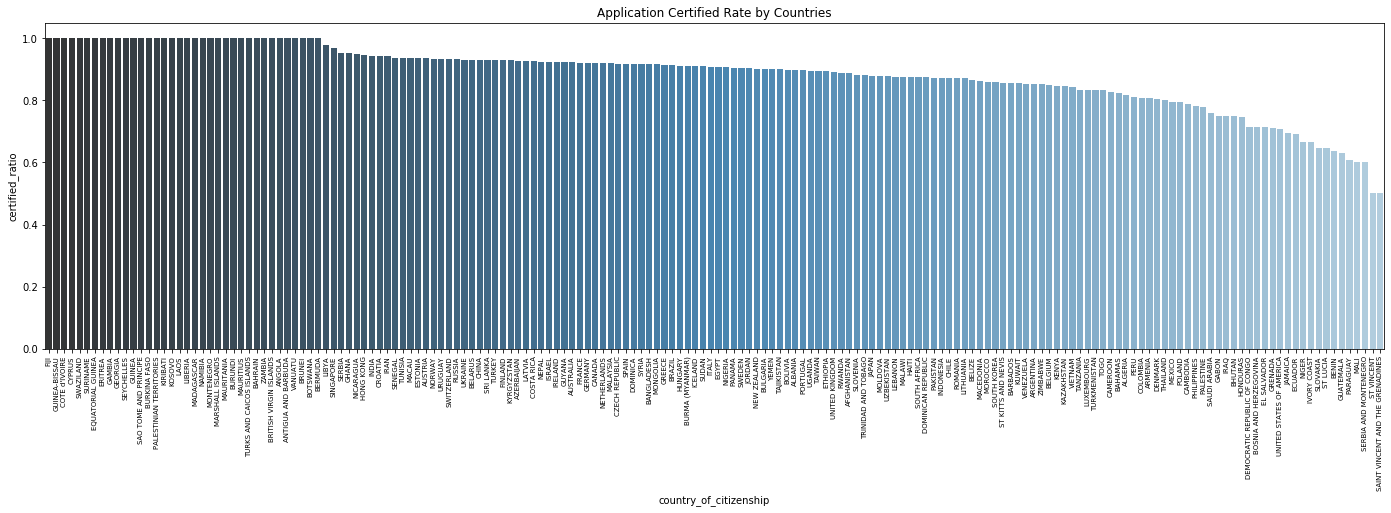

In [50]:
# Plot of Certified Ratio by citizenship
plt.figure(figsize=(24, 6))
plt.xticks(rotation = 90, size='7')
plt.title('Application Certified Rate by Countries')
sns.barplot(x='country_of_citizenship', y='certified_ratio', data=select_df_app_bycitizenship, 
                    palette='Blues_d');

In [53]:
# Certified Ratio by states
select_df_app_bystate = certified_ratio(select_df,'job_state')

In [54]:
state_geo = os.path.join('us-states.json')
m = folium.Map(location=[50, -102], zoom_start=3)
folium.Choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=select_df_app_bystate,
 columns=['job_state', 'total_application'],
 key_on='feature.id',
 fill_color='YlOrRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Permanent Residency Applications'
).add_to(m);
#folium.LayerControl().add_to(m)
m

In [55]:
state_geo = os.path.join('us-states.json')
m = folium.Map(location=[50, -102], zoom_start=3)
folium.Choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=select_df_app_bystate,
 columns=['job_state', 'certified_ratio'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Application Certified Ratio'
).add_to(m);
#folium.LayerControl().add_to(m)
m